<a href="https://www.kaggle.com/code/dodat12/cvlearn-1-semantic-segmentation-w-mobilenetv2?scriptVersionId=163166301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CVLearn#1 - Semantic Segmentation Using MobileNetV2 👁️

# 🕹️ Data Preprocessing
Using pet dataset from The Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

![Annotations Examples](https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

In [1]:
# IMPORT LIB
import os  # link file
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import albumentations as A  # transform

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split  # split dataset
from PIL import Image  # Image object
from torchvision import transforms as T  # transform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# FORDER PATH
IMAGE_PATH = '/kaggle/input/the-oxford-iiit-pet-dataset/images/images/'
MASK_PATH = '/kaggle/input/the-oxford-iiit-pet-dataset/annotations/annotations/trimaps/'

In [3]:
# CREATE DATAFRAME
def create_df():
    # TODO: CREATE DATAFRAME
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        # os.walk() trong Python được sử dụng để duyệt qua tất cả các thư mục và tệp trong một thư mục
        # mỗi lần lặp trả lại 1 tuple 3 phần tử:
        # tên thư mục - danh sách các thư mục con - danh sách các tên tệp trong thư mục
        for filename in filenames:
            if (cv2.imread(IMAGE_PATH + filename.split('.')[0] + '.jpg') is None):
                print(filename)
            else:
                name.append(filename.split('.')[0])
    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))
    # dataframe: name - index


df = create_df()
# check null
print('Total Image: ', len(df))  # 7387

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Egyptian_Mau_145.jpg
Egyptian_Mau_167.jpg
Egyptian_Mau_191.jpg
Egyptian_Mau_177.jpg
Egyptian_Mau_139.jpg


Corrupt JPEG data: premature end of data segment


Abyssinian_34.jpg
Total Image:  7387


In [4]:
# CREATE TRAIN - VALIDATION - TEST SET
# split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

# check null
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  5650
Val Size     :  998
Test Size    :  739


Image Size   :  (500, 375, 3)
Mask Size    :  (500, 375)


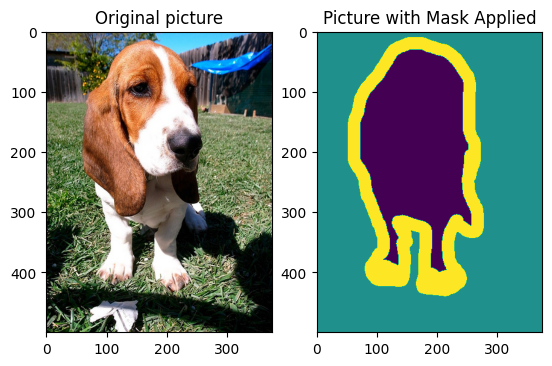

In [5]:
# TEST DATAFRAME ITEMS
img = cv2.imread(IMAGE_PATH + df['id'][100] + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image Size   : ', img.shape)
mask = cv2.imread(MASK_PATH + df['id'][100] + '.png', cv2.IMREAD_GRAYSCALE)
print('Mask Size    : ', mask.shape)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original picture')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Picture with Mask Applied')
plt.show()

In [6]:
# CREATE CLASS DATASET
class DogCatDataset(Dataset):
    # TODO: DATASET CLASS
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X  # dataframe
        self.mean = mean  # average
        self.std = std  # standard deviation - độ lệch chuẩn
        self.transform = transform
        self.patches = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # read from file
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        # print('\n' + self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # img - numpy arr
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        # transform
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)  # cvt numpy arr into Image object

        # chuẩn hóa
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        # if self.patches:
        #     img, mask = self.tiles(img, mask)

        return img, mask

    # def tiles(self, img, mask):
    #     # TODO: Chia nhỏ img và mask thành các ô nhỏ hơn (patch)
    #     # xử lý hình ảnh lớn 1 cách hiệu quả / áp dụng biến đổi cục bộ trên từng vùng
    #     img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
    #     img_patches = img_patches.contiguous().view(3, -1, 512, 768)
    #     img_patches = img_patches.permute(1, 0, 2, 3)
    #
    #     mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
    #     mask_patches = mask_patches.contiguous().view(-1, 512, 768)
    #
    #     return img_patches, mask_patches

In [7]:
# NORMAL DISTRIBUTION para
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [8]:
# DEFINE TRANSFORM
train_size = 384

t_train = A.Compose([
    A.Resize(height=train_size, width=train_size),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast(),
    A.Blur()
])
t_val = A.Compose([
    A.Resize(height=train_size, width=train_size),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

In [9]:
# DEFINE DATASET & DATALOADER
# dataset
train_set = DogCatDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DogCatDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# dataloader
batch_size = 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# check
img, label = next(iter(train_loader))
print(img.shape)
print(label.shape)

torch.Size([3, 3, 384, 384])
torch.Size([3, 384, 384])


# 🛸 Defining model - MobileNetV2

In [10]:
!pip install segmentation_models_pytorch

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import segmentation_models_pytorch as smp

n_classes = 4  # 0, 1, 2, 3

mobilenet_model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=n_classes, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 166MB/s]


# ☣️ Training model

In [12]:
# IMPORT LIB
import torch
import torch.nn as nn
import torch.nn.functional as F  # sigmoid, softmax
import numpy as np
import time

from tqdm.notebook import tqdm  # tracking process

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# DEFINE ACCURACY CALCULATION
def pixel_accuracy(output, mask):
    # TODO: Calculate pixel accuracy
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)  # get the pixel output value using softmax
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    # TODO: Calculate IoU accuracy
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)  # get the pixel output value using softmax
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)  # IoU = phần giao / phần hợp
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
# GET LEARNING RATE
def get_lr(optimizer_):
    for param_group in optimizer_.param_groups:
        return param_group['lr']

In [15]:
# TRAIN LOOP
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            # if patch:
            #     bs, n_tiles, c, h, w = image_tiles.size()
            #
            #     image_tiles = image_tiles.view(-1, c, h, w)
            #     mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            # forward
            output = model(image)
            loss = criterion(output, mask)
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step()  # update weight
            optimizer.zero_grad()  # reset gradient

            # step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    # if patch:
                    #     bs, n_tiles, c, h, w = image_tiles.size()
                    #
                    #     image_tiles = image_tiles.view(-1, c, h, w)
                    #     mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    # evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            # calculation mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'MobileNetV2-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # iou
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    return history

In [16]:
# TRAIN INFO
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mobilenet_model.parameters(), lr=max_lr, weight_decay=weight_decay)
schedule = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

In [17]:
# TRAIN
print('Training start: ')

history = fit(epoch, mobilenet_model, train_loader, val_loader, criterion, optimizer, schedule)
# torch.save(model, 'MobileNetV2-dogcat.pt')

print('Training end!')

Training start: 


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.255 
Epoch:1/15.. Train Loss: 0.395.. Val Loss: 0.255.. Train mIoU:0.810.. Val mIoU: 0.863.. Train Acc:0.864.. Val Acc:0.904.. Time: 4.24m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/15.. Train Loss: 0.288.. Val Loss: 0.283.. Train mIoU:0.844.. Val mIoU: 0.847.. Train Acc:0.895.. Val Acc:0.897.. Time: 4.00m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.283 >> 0.253 
Epoch:3/15.. Train Loss: 0.301.. Val Loss: 0.253.. Train mIoU:0.836.. Val mIoU: 0.859.. Train Acc:0.889.. Val Acc:0.904.. Time: 4.03m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/15.. Train Loss: 0.305.. Val Loss: 0.300.. Train mIoU:0.829.. Val mIoU: 0.836.. Train Acc:0.886.. Val Acc:0.889.. Time: 4.00m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.300 >> 0.264 
Epoch:5/15.. Train Loss: 0.296.. Val Loss: 0.264.. Train mIoU:0.835.. Val mIoU: 0.856.. Train Acc:0.890.. Val Acc:0.901.. Time: 3.99m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.264 >> 0.248 
saving model...
Epoch:6/15.. Train Loss: 0.280.. Val Loss: 0.248.. Train mIoU:0.843.. Val mIoU: 0.862.. Train Acc:0.895.. Val Acc:0.905.. Time: 4.02m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/15.. Train Loss: 0.264.. Val Loss: 0.250.. Train mIoU:0.853.. Val mIoU: 0.867.. Train Acc:0.901.. Val Acc:0.908.. Time: 4.03m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.250 >> 0.217 
Epoch:8/15.. Train Loss: 0.249.. Val Loss: 0.217.. Train mIoU:0.862.. Val mIoU: 0.882.. Train Acc:0.906.. Val Acc:0.917.. Time: 4.02m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/15.. Train Loss: 0.234.. Val Loss: 0.221.. Train mIoU:0.872.. Val mIoU: 0.878.. Train Acc:0.912.. Val Acc:0.916.. Time: 4.00m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.221 >> 0.213 
Epoch:10/15.. Train Loss: 0.220.. Val Loss: 0.213.. Train mIoU:0.880.. Val mIoU: 0.883.. Train Acc:0.917.. Val Acc:0.918.. Time: 4.00m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.213 >> 0.209 
Epoch:11/15.. Train Loss: 0.202.. Val Loss: 0.209.. Train mIoU:0.891.. Val mIoU: 0.889.. Train Acc:0.923.. Val Acc:0.921.. Time: 4.00m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.209 >> 0.191 
Epoch:12/15.. Train Loss: 0.191.. Val Loss: 0.191.. Train mIoU:0.897.. Val mIoU: 0.897.. Train Acc:0.927.. Val Acc:0.926.. Time: 4.01m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:13/15.. Train Loss: 0.181.. Val Loss: 0.192.. Train mIoU:0.903.. Val mIoU: 0.898.. Train Acc:0.930.. Val Acc:0.927.. Time: 3.99m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.192 >> 0.183 
saving model...
Epoch:14/15.. Train Loss: 0.172.. Val Loss: 0.183.. Train mIoU:0.908.. Val mIoU: 0.903.. Train Acc:0.933.. Val Acc:0.930.. Time: 4.02m


  0%|          | 0/1884 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


  0%|          | 0/333 [00:00<?, ?it/s]

Loss Decreasing.. 0.183 >> 0.178 
Epoch:15/15.. Train Loss: 0.171.. Val Loss: 0.178.. Train mIoU:0.909.. Val mIoU: 0.904.. Train Acc:0.934.. Val Acc:0.931.. Time: 4.01m
Total time: 60.36 m
Training end!


In [18]:
# EXPORT MODEL
torch.save(mobilenet_model, 'MobileNetV2-dogcat.pt')

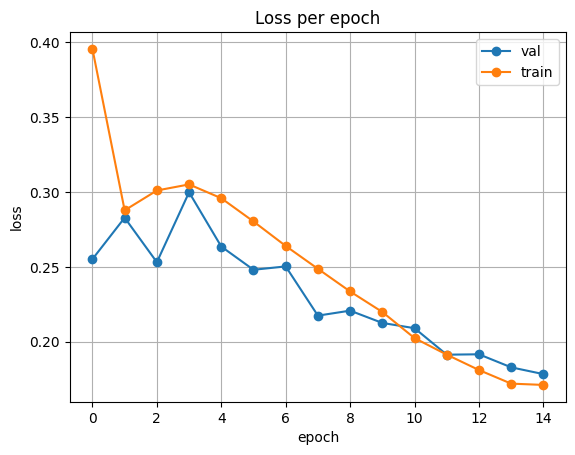

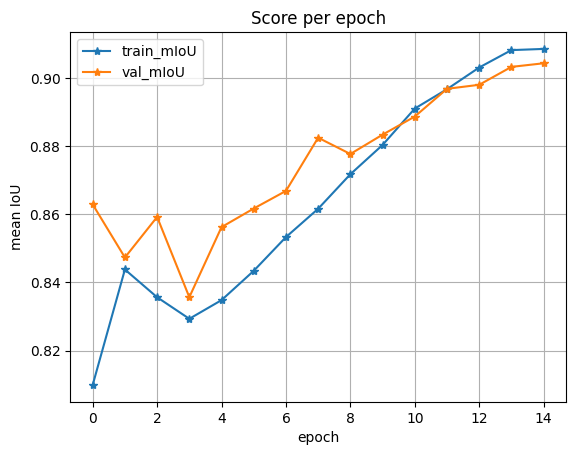

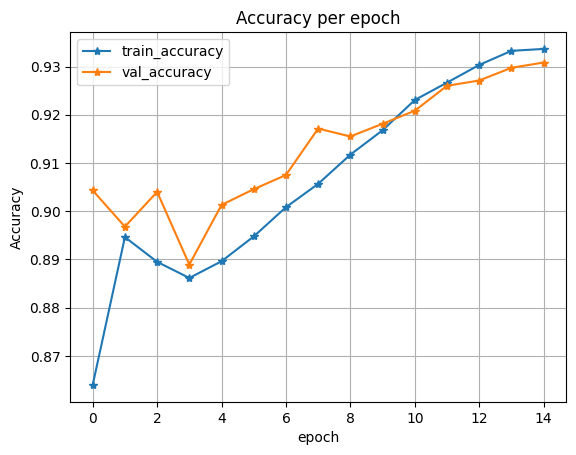

In [19]:
# PLOT TRACKING TRAINING SESS
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

# 🚧 Checking result with test dataset

In [20]:
# CREATE TEST DATASET
class DogCatTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(train_size, train_size, interpolation=cv2.INTER_NEAREST)
test_set = DogCatTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [21]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [22]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [23]:
# TEST
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(mobilenet_model, image, mask)

In [24]:
# CHECK IoU SCORE
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(mobilenet_model, img, mask)
        score_iou.append(score)
    return score_iou
mob_miou = miou_score(mobilenet_model, test_set)
print('Test Set mIoU: ', np.mean(mob_miou))

  0%|          | 0/739 [00:00<?, ?it/s]

Test Set mIoU:  0.8917174766417658


In [25]:
# CHECK Pixel SCORE
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy
mob_acc = pixel_acc(mobilenet_model, test_set)
print('Test Set Pixel Accuracy: ', np.mean(mob_acc))

  0%|          | 0/739 [00:00<?, ?it/s]

Test Set Pixel Accuracy:  0.9302019535948541


# 🥩 Result Example

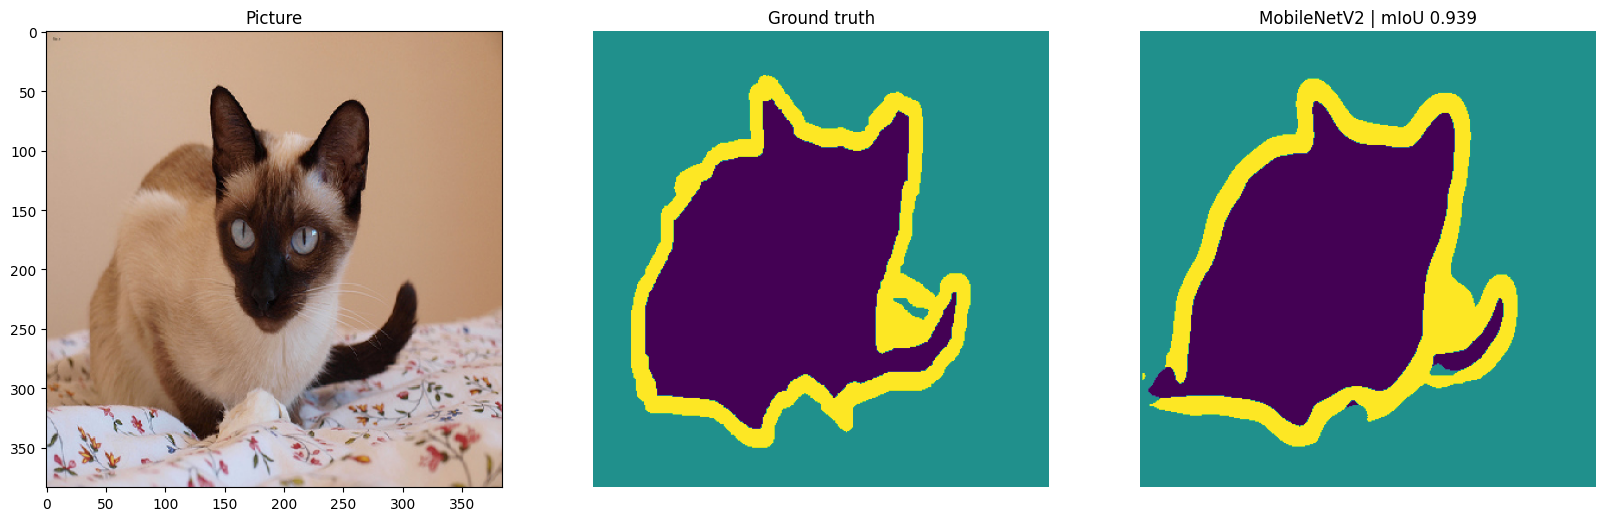

In [26]:
# RESULT
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('MobileNetV2 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

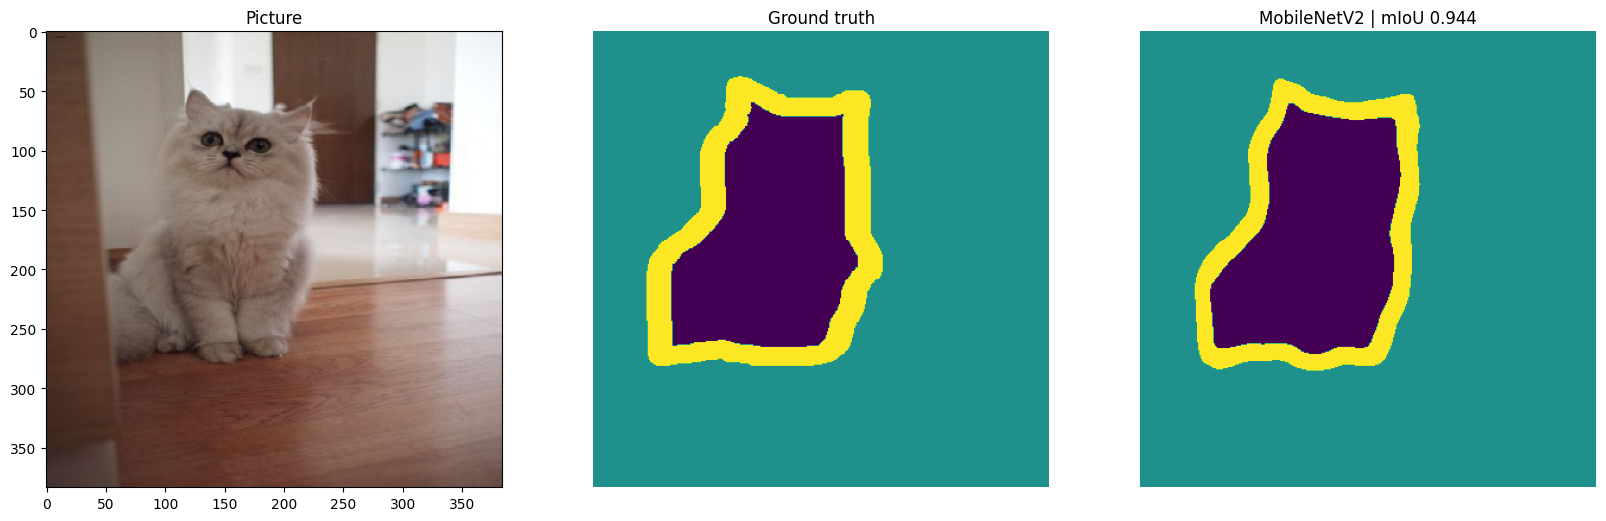

In [27]:
# ANOTHER RESULT
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(mobilenet_model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MobileNetV2 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

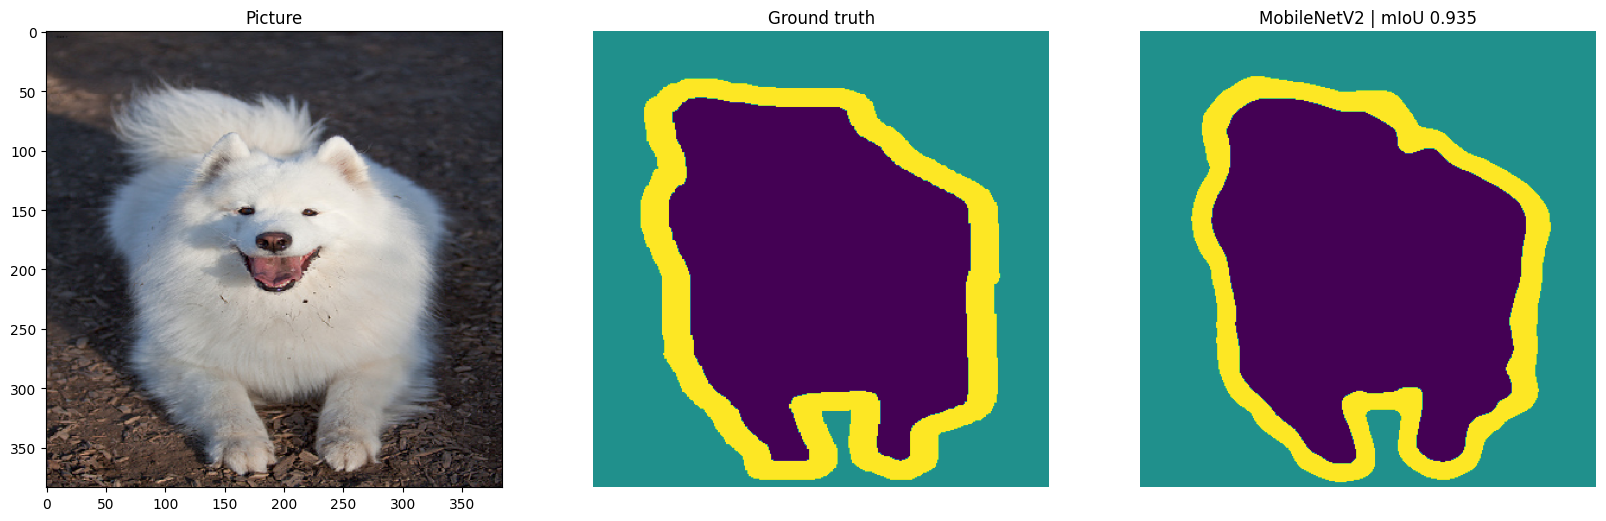

In [28]:
# ANOTHER RESULT
image2, mask2 = test_set[20]
pred_mask2, score2 = predict_image_mask_miou(mobilenet_model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('MobileNetV2 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()